In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import lightcones.linalg as ll
from scipy.sparse.linalg import eigsh, eigs
import scipy.sparse as sparse
from scipy.spatial.distance import cdist

In [28]:
epsilons = [0.1, 0.2]
alphas = [0.2, -0.2]
omegas = [1, 3]
dt = 0.01
t_past = 40
t_future = 40 

In [6]:
n_rel = 4

In [7]:
t_max = t_past + t_future
t = np.arange(0, t_max, dt)
n_t_max = len(t)

In [8]:
n_t_past = int(t_past / dt)
n_t_future = int(t_future / dt)

In [9]:
M = np.zeros(n_t_max) 
for i in range(n_t_max):
    for j in range(len(epsilons)):
        M[i] = M[i] + alphas[j] * math.exp(- epsilons[j] * abs(t[i] - t[0])) * math.sin(omegas[j] * abs(t[i] - t[0]))

In [10]:
def apply_memory_matrix(x):
    x_out = np.zeros(n_t_past)
    for i in range(n_t_future):
        m = M[i:i+n_t_past]
        x_out = x_out + np.vdot(m, x) * m
    return x_out

memory_matrix = sparse.linalg.LinearOperator((n_t_past, n_t_past), matvec=apply_memory_matrix)

In [11]:
def ensure_phase(eigenvectors):
    eigenvectors_corrected = eigenvectors.copy()
    
    for i in range(eigenvectors.shape[1]):
        v = eigenvectors[:, i]
        idx_max = np.argmax(np.abs(v))
        
        if v[idx_max] < 0:
                eigenvectors_corrected[:, i] = -v         
    return eigenvectors_corrected

In [12]:
# zero approximation for relevant vectors
pi, v = eigsh(memory_matrix, k=n_rel, which='LM')
v = ensure_phase(v)

In [13]:
v_in = np.zeros(n_t_past)
v_in[0] = 1

In [14]:
def iterate(v):
    v_shifted = np.vstack((np.zeros(n_rel), v[:-1, :]))
    U = np.column_stack((v_in, v_shifted))
    rho = U.T.conj() @ (memory_matrix @ U)
    pi_, U_ = ll.find_eigs_descending(rho)
    U_ = ensure_phase(U_)
    v_ = U @ U_
    return pi_, U_, v_ 

In [15]:
v_ = np.copy(v)

for i in range(1000):
    pi_, U_, v_ = iterate(v_)
    v_ = v_[:,:-1]

In [16]:
Mv_ = v_.T @ M[:n_t_past] * dt 

In [17]:
def ode_midpoint(dt, RHS, initial_state, start_time = None, start_index = None, end_time = None, end_index = None, tol = 10**(-6)):

    K = initial_state.size

    use_time = False
    use_index = False

    if not start_time is None and not end_time is None:

        use_time = True
        nt = math.floor((end_time - start_time) / dt)

    if not start_index is None and not end_index is None:

        use_index = True
        nt = end_index - start_index

    if not use_index != use_time:
        raise ValueError('evolution should be called either in time or in step-index mode')


    if (use_index):
        yield (start_index, initial_state)
    else:
        yield (start_time, initial_state)

    psi = np.copy(initial_state)
    psi_mid = np.copy(psi)

    b = nt - 1

    for i in range(0, b):

        psi_mid[:] = psi

        if (use_index):
            
            time_moment = start_index + i
            
        else:
            
            time_moment = start_time + (i + 0.5) * dt
            
        while(True):

            psi_mid_next = RHS(time_moment, psi_mid)

            psi_mid_next = psi + dt / 2 * psi_mid_next

            err = max(abs(psi_mid_next - psi_mid))

            swp = psi_mid_next
            psi_mid_next = psi_mid
            psi_mid = swp

            if err < tol:
                break

        psi = 2 * psi_mid - psi

        if (use_index):
            yield (start_index + i + 1, psi)
        else:
            yield (start_time + i * dt, psi)

In [18]:
xi = np.random.normal(size=n_t_max) / math.sqrt(dt)

In [19]:
M_ = np.zeros(n_t_max) 
for i in range(n_t_max):
    for j in range(len(epsilons)):
        M_[i] = M_[i] + alphas[j] * math.exp(- epsilons[j] * abs(t[i] - t[0])) * math.sin(omegas[j] * abs(t[i] - t[0])) * dt

In [20]:
p0 = np.array([0])

p_trajectory = []
t_axis = []

def RHS(ti, p_mid):
    n_memory = len(p_trajectory)
    rhs = -sum(M_[:n_memory+1] * ([p_mid[0]] + p_trajectory[::-1])) + (xi[ti] + xi[ti + 1]) / 2
    return rhs

for ti, p in ode_midpoint(dt, RHS, p0, start_index = 0, end_index = n_t_max - 1):
    p_trajectory.append(p[0])
    t_axis.append(ti * dt)

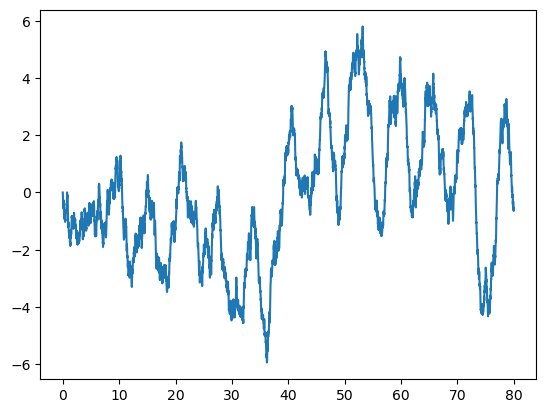

In [21]:
plt.plot(t_axis, p_trajectory)

In [22]:
v_state = np.zeros(n_rel)
p_trajectory_ = [0]

In [23]:
for i in range(1, n_t_max):
    v_in = (xi[i] - np.vdot(Mv_, v_state)) * dt + p_trajectory_[i-1] 
    v_ = np.concatenate([[v_in], v_state])
    v_ = U_.T.conj() @ v_
    v_state = v_[:-1]
    p_trajectory_.append(v_in)


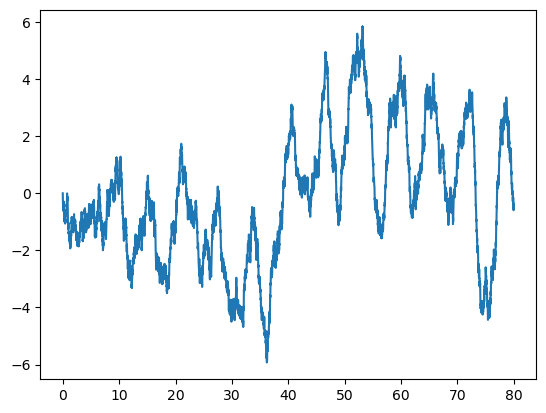

In [24]:
plt.plot(t_axis, p_trajectory_[:-1])

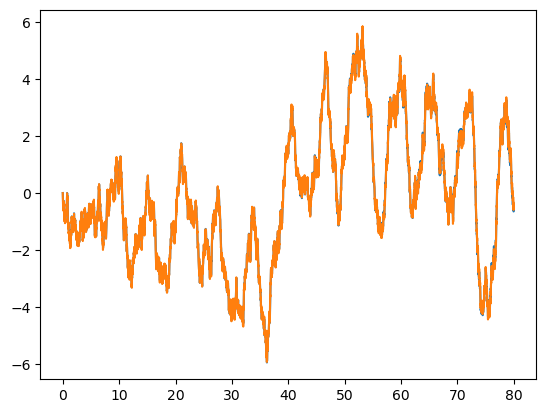

In [25]:
plt.plot(t_axis, p_trajectory)
plt.plot(t_axis, p_trajectory_[:-1])

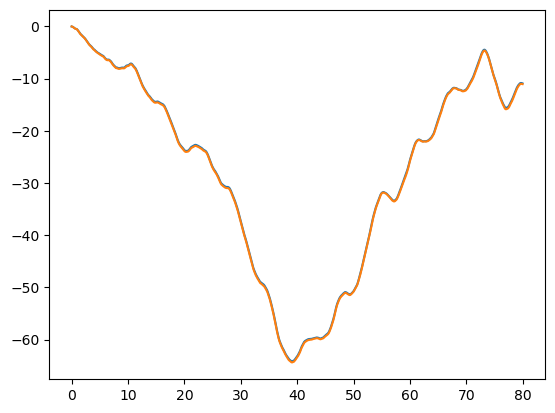

In [26]:
# integrate
x_trajectory = [0]
for i in range(1, len(p_trajectory)):
    x = x_trajectory[i-1] + p_trajectory[i] * dt
    x_trajectory.append(x)

x_trajectory_ = [0]
for i in range(1, len(p_trajectory_[:-1])):
    x = x_trajectory_[i-1] + p_trajectory_[i] * dt
    x_trajectory_.append(x)

plt.plot(t_axis, x_trajectory)
plt.plot(t_axis, x_trajectory_)